In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.manifold import TSNE
from matplotlib import cm
from sklearn.decomposition import PCA

In [3]:
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 10000000000)

In [4]:
!ls hotelwisedata_cleandata

batch-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-dec26_jan24.parquet
batch-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-dec26_jan24.parquet
batch_no_perf_data-jun19_jul19.parquet
batchleft-1-2-3-4-5-jun19_jul19.parquet


In [5]:
data_path='hotelwisedata_cleandata/'

In [6]:
dataset=pd.read_parquet(data_path)

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 34229 entries, 0.0 to 8463.0
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   oyo_id            34229 non-null  object 
 1   hotelid           34229 non-null  int64  
 2   latitude          34229 non-null  float64
 3   longitude         34229 non-null  float64
 4   cluster_id        34229 non-null  int64  
 5   status            34229 non-null  int64  
 6   country_id        34229 non-null  int64  
 7   city_id           34229 non-null  int64  
 8   display_category  34229 non-null  object 
 9   hotelamenitylist  34229 non-null  object 
 10  hotel_ctr         34229 non-null  float64
 11  hotel_btod        34229 non-null  float64
 12  hotel_br          34229 non-null  float64
 13  hotel_rr          34229 non-null  float64
 14  fprice            34229 non-null  float64
 15  ratingCount       30319 non-null  float64
 16  ratingMean        30319 non-null  f

In [8]:
dataset[dataset.country_id==1].status.value_counts()

2    22495
0     1595
3     1170
1      872
6       57
4        1
Name: status, dtype: int64

In [9]:
dataset.city_id.value_counts()

2        1858
4        1094
14       1011
5         947
8         893
         ... 
19416       1
17401       1
1233        1
21755       1
26611       1
Name: city_id, Length: 1724, dtype: int64

## removing old hotelid data (dup hotelid due to multiple batch) (skip if no dup in batches)

In [10]:
batch1_path = 'hotelwisedata_cleandata/batch-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-dec26_jan24.parquet'
batch2_path = 'hotelwisedata_cleandata/batch-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-dec26_jan24.parquet'
batchleft1_path = 'hotelwisedata_cleandata/batchleft-1-2-3-4-5-jun19_jul19.parquet'
batch_noperfdata_path = 'hotelwisedata_cleandata/batch_no_perf_data-jun19_jul19.parquet'


In [11]:
batch1_df=pd.read_parquet(batch1_path)
batch2_df=pd.read_parquet(batch2_path)
batchleft1_df=pd.read_parquet(batchleft1_path)
batch_noperfdata_df=pd.read_parquet(batch_noperfdata_path)

In [12]:
display(batch1_df.hotelid.count(), batch1_df.hotelid.nunique())
display(batch2_df.hotelid.count(), batch2_df.hotelid.nunique())
display(batchleft1_df.hotelid.count(), batchleft1_df.hotelid.nunique())
display(batch_noperfdata_df.hotelid.count(), batch_noperfdata_df.hotelid.nunique())

12043

12043

7268

7268

8464

8464

6454

6454

In [13]:
set(batch1_df.hotelid.values).intersection(set(batch2_df.hotelid.values))

set()

In [14]:
hotelidbatch1=set(batch1_df.hotelid.values).intersection(set(batchleft1_df.hotelid.values))
hotelidbatch2=set(batch2_df.hotelid.values).intersection(set(batchleft1_df.hotelid.values))
hotelidbatch1=list(hotelidbatch1)
hotelidbatch2=list(hotelidbatch2)

In [15]:
batchleft1_df.drop(batchleft1_df[batchleft1_df.hotelid.isin(hotelidbatch1)].index, inplace=True)
batchleft1_df.drop(batchleft1_df[batchleft1_df.hotelid.isin(hotelidbatch2)].index, inplace=True)

In [16]:
batchleft1_df.reset_index(drop=True, inplace=True)

In [17]:
dataset=pd.concat([batch1_df, batch2_df, batchleft1_df, batch_noperfdata_df])

In [18]:
dataset.reset_index(drop=True, inplace=True)

In [19]:
dataset.hotelid.count(), dataset.hotelid.nunique()

(31955, 31955)

## keeping hotels which we show on sp only

In [20]:
dataset[dataset.status.isin([1, 2, 6])].head()

,oyo_id,hotelid,latitude,longitude,cluster_id,status,country_id,city_id,display_category,hotelamenitylist,hotel_ctr,hotel_btod,hotel_br,hotel_rr,fprice,ratingCount,ratingMean
1,ID_BRN023,108295,-3.355645,114.616321,3062,2,96,1021,OYO Hotels,[],0.082547,0.069309,0.009417,0.007937,155641.000000,453.0,4.273141
3,MBL209,108298,17.915144,73.721687,2004,2,1,124,SPOT ON,[],0.064704,0.026770,0.001903,0.185214,833.890937,453.0,4.273141
4,AMI044,108305,20.695522,77.005683,799,2,1,218,OYO Rooms,[],0.069728,0.025135,0.001689,0.075026,1914.395683,453.0,4.273141
6,HYD1590,108316,17.388451,78.478924,97,2,1,8,OYO Rooms,[],0.043227,0.057467,0.003227,0.216477,1025.773973,453.0,4.273141
7,MY_SPN006,108319,4.457612,118.581169,2430,2,5,651,OYO Hotels,[],0.118815,0.017857,0.002551,0.000000,60.333333,453.0,4.273141


In [21]:
dataset.hotelid.count()

31955

In [22]:
dataset.drop(dataset[~dataset.status.isin([1, 2, 6])].index, inplace=True)

In [23]:
dataset.hotelid.count()

27904

## combining cities with less than 10 hotels

In [24]:
city_hotel_count_df = dataset.city_id.value_counts().reset_index().rename(columns={'city_id': 'hotelcount',
                                                                                   'index': 'cityid'}).copy()

In [25]:
city_hotel_count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   cityid      1348 non-null   int64
 1   hotelcount  1348 non-null   int64
dtypes: int64(2)
memory usage: 21.2 KB


In [26]:
city_hotel_10 = city_hotel_count_df[city_hotel_count_df.hotelcount<=10].cityid.values
# city_hotel_20=city_hotel_count_df[city_hotel_count_df.hotelcount>20].cityid.values
# city_hotel_50=city_hotel_count_df[city_hotel_count_df.hotelcount>50].cityid.values

In [27]:
print(list(city_hotel_10))

[345, 5599, 8468, 277, 5421, 766, 148, 419, 186, 5602, 1356, 4629, 208, 113, 363, 152, 839, 205, 994, 5392, 6537, 418, 4440, 381, 5378, 206, 838, 583, 832, 322, 320, 41, 5863, 89, 26233, 130, 624, 149, 1467, 587, 424, 833, 8567, 90, 106, 984, 861, 249, 24482, 605, 1001, 5373, 240, 4770, 127, 768, 140, 143, 315, 863, 887, 778, 144, 447, 5281, 5438, 5449, 17230, 468, 490, 8382, 792, 509, 262, 462, 369, 436, 742, 336, 228, 5427, 17166, 421, 5074, 19310, 718, 823, 257, 1038, 6272, 178, 397, 648, 697, 192, 1238, 248, 751, 289, 5384, 314, 455, 286, 5437, 4710, 658, 1511, 858, 1275, 774, 5390, 2524, 69, 5677, 337, 261, 652, 18634, 4211, 730, 815, 1322, 137, 183, 422, 4992, 756, 595, 535, 238, 17229, 5420, 5293, 1302, 1062, 650, 290, 710, 258, 4719, 83, 17231, 313, 800, 5678, 488, 6282, 699, 1493, 632, 427, 365, 445, 5418, 5402, 390, 5370, 1272, 8404, 797, 209, 174, 542, 5585, 380, 980, 5987, 5339, 8486, 120, 4680, 802, 1026, 187, 428, 410, 5025, 155, 1314, 659, 1330, 4673, 266, 202, 1002, 131

In [28]:
dataset[dataset.city_id.isin(city_hotel_10)].count()[0]

2761

In [29]:
#dataset.loc[dataset[dataset.hotel_br>0.015].index, 'hotel_br']=0.015

In [30]:
dataset[dataset.city_id.isin(city_hotel_10)].index

Int64Index([   50,    56,    59,    68,    85,   129,   147,   155,   162,   164,
            ...
            31316, 31470, 31482, 31564, 31583, 31658, 31684, 31710, 31779, 31887], dtype='int64', length=2761)

In [31]:
dataset.loc[dataset.city_id.isin(city_hotel_10), 'city_id']=0

# display category

In [32]:
dataset.display_category.value_counts()

OYO Rooms        12459
OYO Hotels        5203
SPOT ON           2610
Capital O         2208
Premium           1291
Home              1205
Collection O       851
Flagship           798
Townhouse          414
OYO Living         251
Silverkey          239
OYOxDesign         199
Belvilla            56
Houseboat           32
Ryokan              24
Palette             21
Townhouse Oak       16
Silver Key          15
Home Luxe            6
OYO X                1
5 by OYO             1
4 by OYO             1
3 by OYO             1
Mountania            1
Mid Range            1
Name: display_category, dtype: int64

In [33]:
dataset['display_category']=dataset['display_category'].fillna('OYO Rooms')

dataset['display_category']=dataset['display_category'].str.replace('Silver Key', 'Silverkey')
dataset['display_category']=dataset['display_category'].str.replace('Townhouse Oak', 'Townhouse')

dataset['display_category']=dataset['display_category'].str.replace('Mountania', 'Others')
dataset['display_category']=dataset['display_category'].str.replace('Mid Range', 'Others')
dataset['display_category']=dataset['display_category'].str.replace('OYO X', 'Others')
dataset['display_category']=dataset['display_category'].str.replace('3 by OYO', 'Others')
dataset['display_category']=dataset['display_category'].str.replace('4 by OYO', 'Others')
dataset['display_category']=dataset['display_category'].str.replace('5 by OYO', 'Others')
dataset['display_category']=dataset['display_category'].str.replace('Home Luxe', 'Others')
dataset['display_category']=dataset['display_category'].str.replace('Houseboat', 'Others')
dataset['display_category']=dataset['display_category'].str.replace('Ryokan', 'Others')
dataset['display_category']=dataset['display_category'].str.replace('Palette', 'Others')

dataset.display_category.value_counts()

OYO Rooms       12459
OYO Hotels       5203
SPOT ON          2610
Capital O        2208
Premium          1291
Home             1205
Collection O      851
Flagship          798
Townhouse         430
Silverkey         254
OYO Living        251
OYOxDesign        199
Others             89
Belvilla           56
Name: display_category, dtype: int64

## price conversion

In [34]:
dataset.country_id.value_counts()

1      21740
96      2970
5        831
8        646
217      368
211      268
160      226
104      223
210      160
172      157
209      106
36        71
132       67
183       22
7         20
152       17
25         8
43         3
177        1
Name: country_id, dtype: int64

In [35]:
# price conversion map
price_conversion_map = {
    1: 1,
    96: 0.0051,
    5: 17.69,
    104: 0.68,
    8: 2.27,
    217: 0.0032,
    132: 3.72,
    36: 14.20,
    7: 0.62,
    209: 20.31,
    160: 1.47,
    211: 74.62,
    210: 101.91,
    184: 0.37,
    183: 87.85,
    152: 193.93,
    25: 198.06,
    43: 58.55,
    177: 54.59,
    80: 87.85,
    64: 4.77,
    99: 87.85,
    74: 87.85,
    162: 87.85,
    101: 87.84
}

In [36]:
price_conversion_map.keys()

dict_keys([1, 96, 5, 104, 8, 217, 132, 36, 7, 209, 160, 211, 210, 184, 183, 152, 25, 43, 177, 80, 64, 99, 74, 162, 101])

In [37]:
dataset.drop(dataset[~dataset.country_id.isin(price_conversion_map.keys())].index, inplace=True)

In [38]:
dataset.reset_index(drop=True, inplace=True)

In [39]:
dataset.fprice.describe()

count    2.774700e+04
mean     1.608879e+14
std      1.853767e+16
min      0.000000e+00
25%      9.507625e+02
50%      1.650273e+03
75%      3.204964e+03
max      3.074457e+18
Name: fprice, dtype: float64

In [40]:
def convert_fprice(row):
    return row.fprice*price_conversion_map[row.country_id]

In [41]:
dataset['converted_price']=dataset.apply(convert_fprice, axis=1)

In [42]:
dataset.converted_price.describe()

count    2.774700e+04
mean     1.636173e+14
std      1.480562e+16
min      0.000000e+00
25%      9.318114e+02
50%      1.430130e+03
75%      2.877569e+03
max      2.255688e+18
Name: converted_price, dtype: float64

In [43]:
dataset.drop(columns=['fprice'], inplace=True)

In [44]:
dataset.rename(columns={'converted_price': 'fprice'}, inplace=True)

# fprice

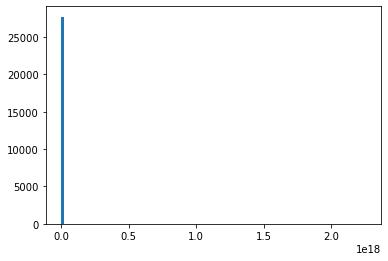

In [45]:
arr=plt.hist(dataset['fprice'], bins=100, histtype='bar')

In [46]:
dataset['fprice'].describe().round(8)

count    2.774700e+04
mean     1.636173e+14
std      1.480562e+16
min      0.000000e+00
25%      9.318114e+02
50%      1.430130e+03
75%      2.877569e+03
max      2.255688e+18
Name: fprice, dtype: float64

In [47]:
#dataset[dataset.fprice>50000]

In [48]:
dataset[dataset.fprice>50000]['display_category'].unique(), dataset[dataset.fprice>50000]['display_category'].value_counts()


(array(['SPOT ON', 'OYO Rooms', 'OYO Hotels', 'Collection O', 'Capital O',
        'OYO Living', 'Premium', 'Silverkey', 'Townhouse', 'Flagship',
        'Home'], dtype=object),
 OYO Rooms       27
 OYO Hotels      13
 Capital O        9
 SPOT ON          8
 Premium          3
 Collection O     3
 Flagship         2
 Townhouse        2
 Home             2
 Silverkey        1
 OYO Living       1
 Name: display_category, dtype: int64)

In [49]:
dataset[(dataset.fprice<50000) & (dataset.display_category.isin(dataset[dataset.fprice>50000]['display_category'].unique()))
       ][['fprice', 'display_category']].groupby('display_category').mean()


,fprice
display_category,
Capital O,1873.502268
Collection O,1811.734163
Flagship,1875.085107
Home,2035.264874
OYO Hotels,2016.065062
OYO Living,1970.738028
OYO Rooms,1939.416987
Premium,2693.583653
SPOT ON,1331.918809


In [50]:
for display_cat in dataset[dataset.fprice>50000]['display_category'].unique():
    dataset.loc[dataset[(dataset.fprice>50000) 
                        & (dataset.display_category==display_cat)].index, 'fprice'
               ]=dataset[(dataset.fprice<50000) 
                         & (dataset.display_category==display_cat)
                        ][['fprice', 'display_category']].groupby('display_category').mean().fprice[0]


In [51]:
dataset[(dataset.fprice>50000)]

,oyo_id,hotelid,latitude,longitude,cluster_id,status,country_id,city_id,display_category,hotelamenitylist,hotel_ctr,hotel_btod,hotel_br,hotel_rr,ratingCount,ratingMean,fprice


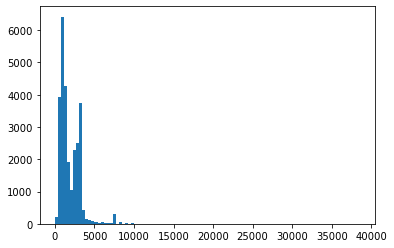

In [52]:
arr=plt.hist(dataset['fprice'], bins=100, histtype='bar')

In [53]:
# clipping fprice

In [54]:
dataset[(dataset.fprice>8000) & (dataset.fprice<50000)]['hotelid'].nunique()

160

In [55]:
dataset[(dataset.fprice<350)]['fprice'].count()

177

In [56]:
dataset[(dataset.fprice>7700)]['fprice'].count()

169

In [57]:
dataset.loc[dataset[dataset.fprice<350].index, 'fprice']=350.0

In [58]:
dataset.loc[dataset[dataset.fprice>8000].index, 'fprice']=8000.0

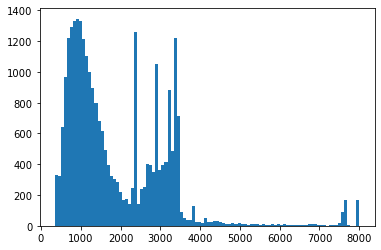

In [59]:
arr=plt.hist(dataset['fprice'], bins=100, histtype='bar')

In [60]:
#arr=plt.hist(np.log10(dataset[dataset.fprice>0.0]['fprice']), bins=200, histtype='bar')

In [61]:
# normalising price (min-max) or standardisation (Z-score)

In [62]:
dataset['fprice_nor']=(dataset['fprice']-dataset['fprice'].min())/(dataset['fprice'].max()-dataset['fprice'].min())

In [63]:
dataset['fprice_stdn']=(dataset['fprice']-dataset['fprice'].mean())/(dataset['fprice'].std())

In [64]:
dataset[['fprice_nor', 'fprice_stdn']]

,fprice_nor,fprice_stdn
0,0.058009,-0.849337
1,0.063254,-0.818804
2,0.204496,0.003460
3,0.088336,-0.672781
4,0.093764,-0.641182
...,...,...
27742,0.304551,0.585943
27743,0.336542,0.772186
27744,0.399028,1.135958
27745,0.166755,-0.216254


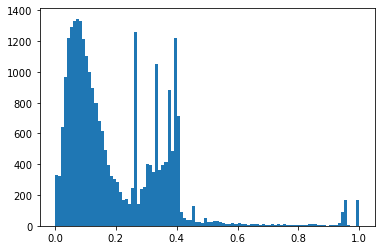

In [65]:
arr=plt.hist(dataset['fprice_nor'], bins=100, histtype='bar')

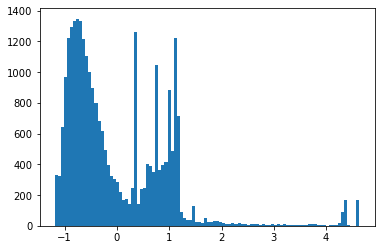

In [66]:
arr=plt.hist(dataset['fprice_stdn'], bins=100, histtype='bar')

# rating

In [67]:
sum(dataset.ratingMean.isna())

3854

In [68]:
dataset.ratingMean.fillna(dataset.ratingMean.mean(), inplace=True)

In [69]:
dataset[dataset['ratingMean']<=3].count()[0], dataset.count()[0]

(823, 27747)

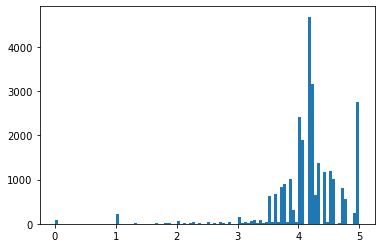

In [70]:
arr=plt.hist(dataset['ratingMean'], bins=100, histtype='bar')

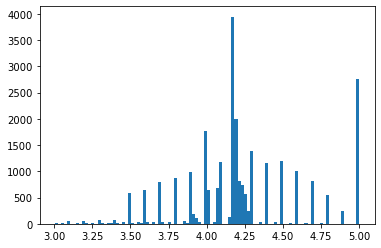

In [71]:
arr=plt.hist(dataset[dataset.ratingMean>3.0]['ratingMean'], bins=100, histtype='bar')

In [72]:
dataset.loc[dataset[dataset.ratingMean<2.0].index, 'ratingMean']=2.0

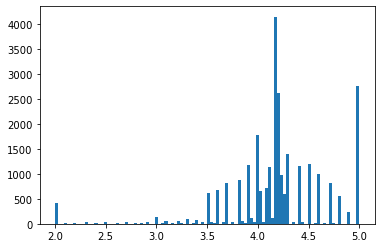

In [73]:
arr=plt.hist(dataset['ratingMean'], bins=100, histtype='bar')

In [74]:
dataset['rating_nor']=(dataset['ratingMean']-dataset['ratingMean'].min())/(dataset['ratingMean'].max()-dataset['ratingMean'].min())


# ratingcount

In [75]:
sum(dataset.ratingCount.isna())

3854

In [76]:
dataset.ratingCount.fillna(dataset.ratingCount.mean(), inplace=True)

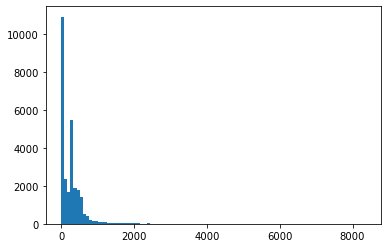

In [77]:
arr=plt.hist(dataset['ratingCount'], bins=100, histtype='bar')

In [78]:
dataset.ratingCount.describe()

count    27747.000000
mean       252.476248
std        349.789496
min          1.000000
25%         23.000000
50%        190.000000
75%        344.000000
max       8361.000000
Name: ratingCount, dtype: float64

In [79]:
dataset[dataset.ratingCount==0.0]['ratingCount']

Series([], Name: ratingCount, dtype: float64)

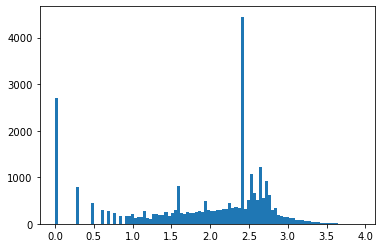

In [80]:
arr=plt.hist(np.log10(dataset[dataset.ratingCount>0.0]['ratingCount']), bins=100, histtype='bar')

In [81]:
dataset['rcount_log10']=np.log10(dataset[dataset.ratingCount>0.0]['ratingCount'])

In [82]:
dataset.rcount_log10.fillna(0.0, inplace=True)

In [83]:
dataset['rcount_log10_nor']=(dataset['rcount_log10']-dataset['rcount_log10'].min())/(dataset['rcount_log10'].max()-dataset['rcount_log10'].min())


In [84]:
dataset=dataset.drop(columns=['rcount_log10'])

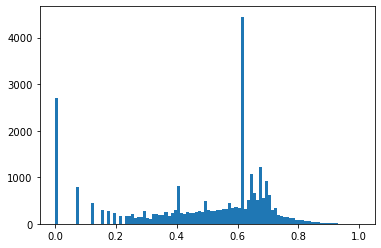

In [85]:
arr=plt.hist(dataset['rcount_log10_nor'], bins=100, histtype='bar')

# hotel ctr

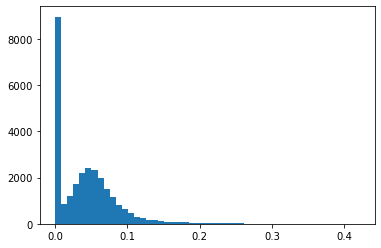

In [86]:
arr=plt.hist(dataset['hotel_ctr'], bins=50, histtype='bar')

In [87]:
dataset[dataset.hotel_ctr>0.28].hotel_ctr.count()

45

In [88]:
#change this val
dataset.loc[dataset[dataset.hotel_ctr>0.25].index, 'hotel_ctr']=0.25

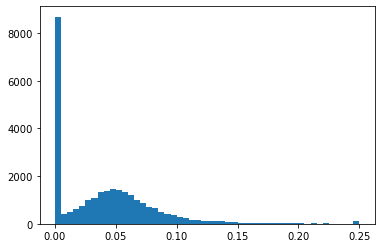

In [89]:
arr=plt.hist(dataset['hotel_ctr'], bins=50, histtype='bar')

In [90]:
dataset['hotel_ctr_nor']=(dataset['hotel_ctr']-dataset['hotel_ctr'].min())/(dataset['hotel_ctr'].max()-dataset['hotel_ctr'].min())


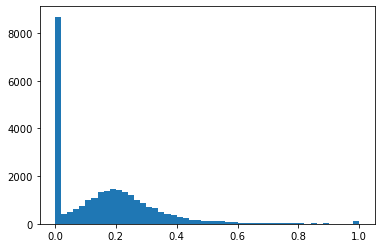

In [91]:
arr=plt.hist(dataset['hotel_ctr_nor'], bins=50, histtype='bar')

# hotel btod

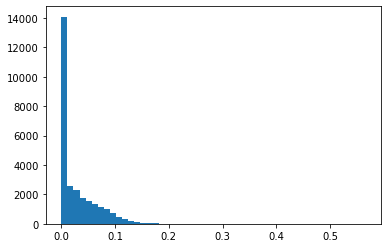

In [92]:
arr=plt.hist(dataset['hotel_btod'], bins=50, histtype='bar')

In [93]:
dataset[dataset.hotel_btod>0.170].hotel_btod.count()

118

In [94]:
#change this val
dataset.loc[dataset[dataset.hotel_btod>0.170].index, 'hotel_btod']=0.170

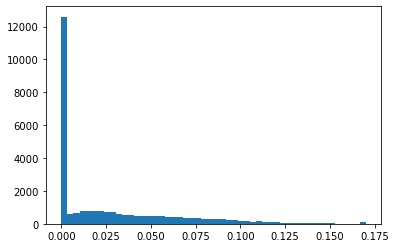

In [95]:
arr=plt.hist(dataset['hotel_btod'], bins=50, histtype='bar')

In [96]:
dataset['hotel_btod_nor']=(dataset['hotel_btod']-dataset['hotel_btod'].min())/(dataset['hotel_btod'].max()-dataset['hotel_btod'].min())


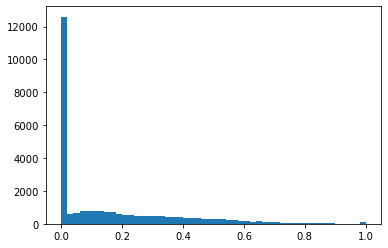

In [97]:
arr=plt.hist(dataset['hotel_btod_nor'], bins=50, histtype='bar')

# hotel br

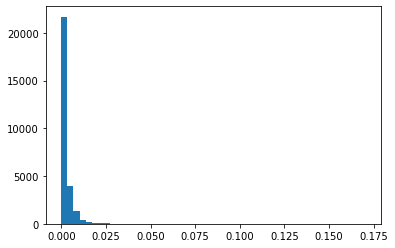

In [98]:
arr=plt.hist(dataset['hotel_br'], bins=50, histtype='bar')

In [99]:
dataset[dataset.hotel_br>0.02].hotel_br.count()

215

In [100]:
#change this val
dataset.loc[dataset[dataset.hotel_br>0.02].index, 'hotel_br']=0.02

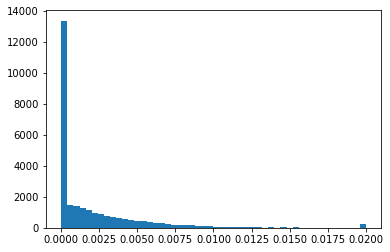

In [101]:
arr=plt.hist(dataset['hotel_br'], bins=50, histtype='bar')

In [102]:
dataset['hotel_br_nor']=(dataset['hotel_br']-dataset['hotel_br'].min())/(dataset['hotel_br'].max()-dataset['hotel_br'].min())


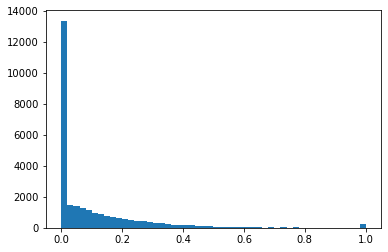

In [103]:
arr=plt.hist(dataset['hotel_br_nor'], bins=50, histtype='bar')

# hotel rr

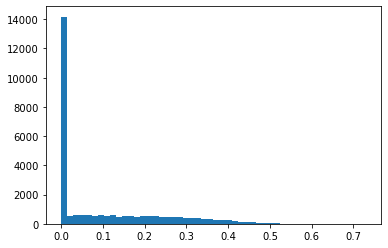

In [104]:
arr=plt.hist(dataset['hotel_rr'], bins=50, histtype='bar')

In [105]:
dataset[dataset.hotel_rr>0.55].hotel_rr.count()

74

In [106]:
#change this val
dataset.loc[dataset[dataset.hotel_rr>0.55].index, 'hotel_rr']=0.55

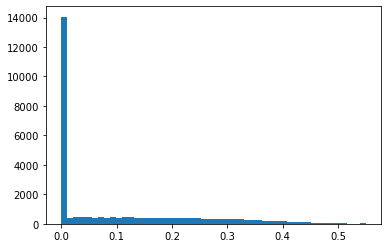

In [107]:
arr=plt.hist(dataset['hotel_rr'], bins=50, histtype='bar')

In [108]:
dataset['hotel_rr_nor']=(dataset['hotel_rr']-dataset['hotel_rr'].min())/(dataset['hotel_rr'].max()-dataset['hotel_rr'].min())


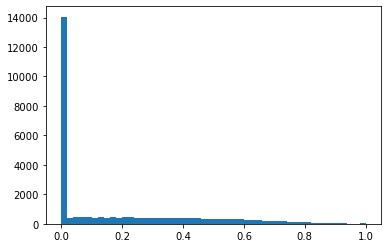

In [109]:
arr=plt.hist(dataset['hotel_rr_nor'], bins=50, histtype='bar')

# lat long

In [110]:
# x = cos(lat) * cos(lon)
# y = cos(lat) * sin(lon), 
# z = sin(lat) 

In [111]:
dataset['xcord']=np.cos(dataset.latitude)*np.cos(dataset.longitude)
dataset['ycord']=np.cos(dataset.latitude)*np.sin(dataset.longitude)
dataset['zcord']=np.sin(dataset.latitude)

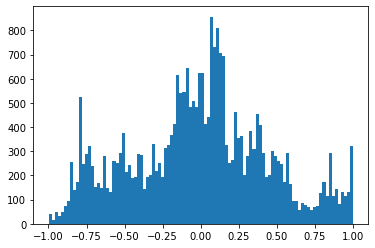

In [112]:
arr=plt.hist(dataset['xcord'], bins=100, histtype='bar')

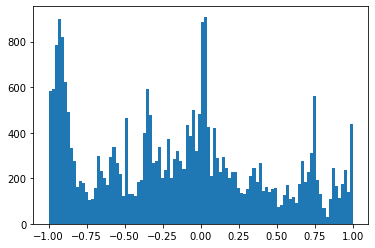

In [113]:
arr=plt.hist(dataset['ycord'], bins=100, histtype='bar')

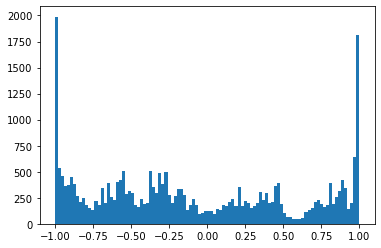

In [114]:
arr=plt.hist(dataset['zcord'], bins=100, histtype='bar')

In [115]:
dataset['xcord_nor']=(dataset['xcord']-dataset['xcord'].min())/(dataset['xcord'].max()-dataset['xcord'].min())
dataset['ycord_nor']=(dataset['ycord']-dataset['ycord'].min())/(dataset['ycord'].max()-dataset['ycord'].min())
dataset['zcord_nor']=(dataset['zcord']-dataset['zcord'].min())/(dataset['zcord'].max()-dataset['zcord'].min())

In [116]:
dataset.head()

,oyo_id,hotelid,latitude,longitude,cluster_id,status,country_id,city_id,display_category,hotelamenitylist,hotel_ctr,hotel_btod,hotel_br,hotel_rr,ratingCount,ratingMean,fprice,fprice_nor,fprice_stdn,rating_nor,rcount_log10_nor,hotel_ctr_nor,hotel_btod_nor,hotel_br_nor,hotel_rr_nor,xcord,ycord,zcord,xcord_nor,ycord_nor,zcord_nor
0,ID_BRN023,108295,-3.355645,114.616321,3062,2,96,1021,OYO Hotels,[],0.082547,0.069309,0.009417,0.007937,453.0,4.273141,793.769100,0.058009,-0.849337,0.757714,0.677186,0.330188,0.407697,0.470859,0.014430,-0.050606,-0.975867,0.212422,0.474594,0.011999,0.606211
1,MBL209,108298,17.915144,73.721687,2004,2,1,124,SPOT ON,[],0.064704,0.026770,0.001903,0.185214,453.0,4.273141,833.890937,0.063254,-0.818804,0.757714,0.677186,0.258816,0.157468,0.095150,0.336753,-0.062724,-0.590972,-0.804250,0.468534,0.204463,0.097875
2,AMI044,108305,20.695522,77.005683,799,2,1,218,OYO Rooms,[],0.069728,0.025135,0.001689,0.075026,453.0,4.273141,1914.395683,0.204496,0.003460,0.757714,0.677186,0.278912,0.147852,0.084455,0.136410,0.009959,-0.271528,0.962379,0.504883,0.364199,0.981190
3,HYD1590,108316,17.388451,78.478924,97,2,1,8,OYO Rooms,[],0.043227,0.057467,0.003227,0.216477,453.0,4.273141,1025.773973,0.088336,-0.672781,0.757714,0.677186,0.172910,0.338039,0.161325,0.393594,-0.109269,0.006662,-0.993990,0.445257,0.503306,0.003005
4,MY_SPN006,108319,4.457612,118.581169,2430,2,5,651,OYO Hotels,[],0.118815,0.017857,0.002551,0.000000,453.0,4.273141,1067.296667,0.093764,-0.641182,0.757714,0.677186,0.475260,0.105042,0.127551,0.000000,-0.175708,0.180681,-0.967720,0.412031,0.590323,0.016140


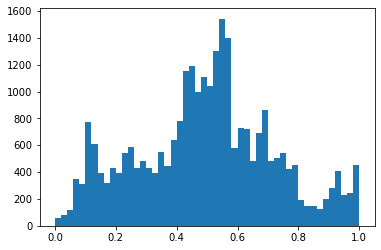

In [117]:
arr=plt.hist(dataset['xcord_nor'], bins=50, histtype='bar')

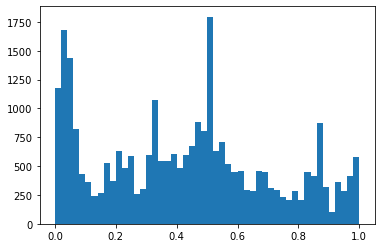

In [118]:
arr=plt.hist(dataset['ycord_nor'], bins=50, histtype='bar')

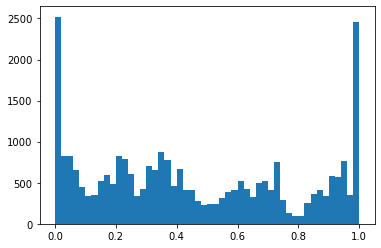

In [119]:
arr=plt.hist(dataset['zcord_nor'], bins=50, histtype='bar')

# ONE HOT

## Amenities

In [120]:
imp_amenities=[3, 13, 81]
imp_amenities.sort()
imp_amenities

[3, 13, 81]

In [121]:
for amenity in imp_amenities:
    dataset["amenity_"+str(amenity)]=None

In [122]:
dataset

,oyo_id,hotelid,latitude,longitude,cluster_id,status,country_id,city_id,display_category,hotelamenitylist,hotel_ctr,hotel_btod,hotel_br,hotel_rr,ratingCount,ratingMean,fprice,fprice_nor,fprice_stdn,rating_nor,rcount_log10_nor,hotel_ctr_nor,hotel_btod_nor,hotel_br_nor,hotel_rr_nor,xcord,ycord,zcord,xcord_nor,ycord_nor,zcord_nor,amenity_3,amenity_13,amenity_81
0,ID_BRN023,108295,-3.355645,114.616321,3062,2,96,1021,OYO Hotels,[],0.082547,0.069309,0.009417,0.007937,453.000000,4.273141,793.769100,0.058009,-0.849337,0.757714,0.677186,0.330188,0.407697,0.470859,0.014430,-0.050606,-0.975867,0.212422,0.474594,0.011999,0.606211,None,None,None
1,MBL209,108298,17.915144,73.721687,2004,2,1,124,SPOT ON,[],0.064704,0.026770,0.001903,0.185214,453.000000,4.273141,833.890937,0.063254,-0.818804,0.757714,0.677186,0.258816,0.157468,0.095150,0.336753,-0.062724,-0.590972,-0.804250,0.468534,0.204463,0.097875,None,None,None
2,AMI044,108305,20.695522,77.005683,799,2,1,218,OYO Rooms,[],0.069728,0.025135,0.001689,0.075026,453.000000,4.273141,1914.395683,0.204496,0.003460,0.757714,0.677186,0.278912,0.147852,0.084455,0.136410,0.009959,-0.271528,0.962379,0.504883,0.364199,0.981190,None,None,None
3,HYD1590,108316,17.388451,78.478924,97,2,1,8,OYO Rooms,[],0.043227,0.057467,0.003227,0.216477,453.000000,4.273141,1025.773973,0.088336,-0.672781,0.757714,0.677186,0.172910,0.338039,0.161325,0.393594,-0.109269,0.006662,-0.993990,0.445257,0.503306,0.003005,None,None,None
4,MY_SPN006,108319,4.457612,118.581169,2430,2,5,651,OYO Hotels,[],0.118815,0.017857,0.002551,0.000000,453.000000,4.273141,1067.296667,0.093764,-0.641182,0.757714,0.677186,0.475260,0.105042,0.127551,0.000000,-0.175708,0.180681,-0.967720,0.412031,0.590323,0.016140,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27742,JAI367,16105,26.885934,75.752352,752,2,1,7,OYO Rooms,"[17, 38, 3, 86, 1, 21, 75, 34, 81, 20, 80, 13,...",0.000000,0.000000,0.000000,0.000000,2.000000,4.500000,2679.814024,0.304551,0.585943,0.833333,0.076749,0.000000,0.000000,0.000000,0.000000,-0.170132,-0.062900,0.983412,0.414820,0.468522,0.991706,None,None,None
27743,IND146,16031,22.755930,75.896480,167,2,1,27,OYO Rooms,"[38, 154, 3, 7, 76, 13, 20, 86]",0.000000,0.000000,0.000000,0.000000,22.000000,4.200000,2924.548428,0.336542,0.772186,0.733333,0.342258,0.000000,0.000000,0.000000,0.000000,-0.633808,-0.344817,-0.692379,0.182937,0.327551,0.153810,None,None,None
27744,JAI373,16564,26.847647,75.776341,752,2,1,7,OYO Rooms,"[7, 80, 1, 86, 38, 76, 154, 75, 13, 81, 34, 17...",0.000000,0.000000,0.000000,0.000000,252.476248,4.171150,3402.567343,0.399028,1.135958,0.723717,0.612459,0.000000,0.000000,0.000000,0.000000,-0.133467,-0.053017,0.989634,0.433156,0.473464,0.994817,None,None,None
27745,SHI044,16562,19.775248,74.476172,145,2,1,22,OYO Rooms,"[7, 17, 81, 3, 86, 76, 34, 13, 48, 85, 38, 1]",0.000000,0.000000,0.000000,0.000000,18.000000,4.000000,1625.678855,0.166755,-0.216254,0.666667,0.320038,0.000000,0.000000,0.000000,0.000000,0.363286,-0.479127,0.799037,0.681581,0.260390,0.899519,None,None,None


In [123]:
def top_amenity_update(row):
    for amenity in imp_amenities:
        if amenity in set(row.hotelamenitylist):
            row["amenity_"+str(amenity)]=1
        else:
            row["amenity_"+str(amenity)]=0
    return row

In [124]:
dataset=dataset.apply(top_amenity_update, axis=1)

## one hot func

In [125]:
dataset.head()

,oyo_id,hotelid,latitude,longitude,cluster_id,status,country_id,city_id,display_category,hotelamenitylist,hotel_ctr,hotel_btod,hotel_br,hotel_rr,ratingCount,ratingMean,fprice,fprice_nor,fprice_stdn,rating_nor,rcount_log10_nor,hotel_ctr_nor,hotel_btod_nor,hotel_br_nor,hotel_rr_nor,xcord,ycord,zcord,xcord_nor,ycord_nor,zcord_nor,amenity_3,amenity_13,amenity_81
0,ID_BRN023,108295,-3.355645,114.616321,3062,2,96,1021,OYO Hotels,[],0.082547,0.069309,0.009417,0.007937,453.0,4.273141,793.769100,0.058009,-0.849337,0.757714,0.677186,0.330188,0.407697,0.470859,0.014430,-0.050606,-0.975867,0.212422,0.474594,0.011999,0.606211,0,0,0
1,MBL209,108298,17.915144,73.721687,2004,2,1,124,SPOT ON,[],0.064704,0.026770,0.001903,0.185214,453.0,4.273141,833.890937,0.063254,-0.818804,0.757714,0.677186,0.258816,0.157468,0.095150,0.336753,-0.062724,-0.590972,-0.804250,0.468534,0.204463,0.097875,0,0,0
2,AMI044,108305,20.695522,77.005683,799,2,1,218,OYO Rooms,[],0.069728,0.025135,0.001689,0.075026,453.0,4.273141,1914.395683,0.204496,0.003460,0.757714,0.677186,0.278912,0.147852,0.084455,0.136410,0.009959,-0.271528,0.962379,0.504883,0.364199,0.981190,0,0,0
3,HYD1590,108316,17.388451,78.478924,97,2,1,8,OYO Rooms,[],0.043227,0.057467,0.003227,0.216477,453.0,4.273141,1025.773973,0.088336,-0.672781,0.757714,0.677186,0.172910,0.338039,0.161325,0.393594,-0.109269,0.006662,-0.993990,0.445257,0.503306,0.003005,0,0,0
4,MY_SPN006,108319,4.457612,118.581169,2430,2,5,651,OYO Hotels,[],0.118815,0.017857,0.002551,0.000000,453.0,4.273141,1067.296667,0.093764,-0.641182,0.757714,0.677186,0.475260,0.105042,0.127551,0.000000,-0.175708,0.180681,-0.967720,0.412031,0.590323,0.016140,0,0,0


In [126]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27747 entries, 0 to 27746
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   oyo_id            27747 non-null  object 
 1   hotelid           27747 non-null  int64  
 2   latitude          27747 non-null  float64
 3   longitude         27747 non-null  float64
 4   cluster_id        27747 non-null  int64  
 5   status            27747 non-null  int64  
 6   country_id        27747 non-null  int64  
 7   city_id           27747 non-null  int64  
 8   display_category  27747 non-null  object 
 9   hotelamenitylist  27747 non-null  object 
 10  hotel_ctr         27747 non-null  float64
 11  hotel_btod        27747 non-null  float64
 12  hotel_br          27747 non-null  float64
 13  hotel_rr          27747 non-null  float64
 14  ratingCount       27747 non-null  float64
 15  ratingMean        27747 non-null  float64
 16  fprice            27747 non-null  float6

In [127]:
def encode_concat(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]].astype({feature_to_encode: str}))
    res = pd.concat([original_dataframe, dummies], axis=1)
    return(res)

def encode_concat_drop(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

## display category

In [128]:
dataset.display_category.value_counts()

OYO Rooms       12459
OYO Hotels       5056
SPOT ON          2610
Capital O        2204
Premium          1285
Home             1205
Collection O      851
Flagship          798
Townhouse         430
Silverkey         254
OYO Living        251
OYOxDesign        199
Others             89
Belvilla           56
Name: display_category, dtype: int64

In [129]:
dataset=encode_concat(dataset, 'display_category')

In [130]:
# pd.get_dummies(dataset1.city_id.astype(str))
# pd.get_dummies(dataset1.cluster_id.astype(str))

In [131]:
dataset.head()

,oyo_id,hotelid,latitude,longitude,cluster_id,status,country_id,city_id,display_category,hotelamenitylist,hotel_ctr,hotel_btod,hotel_br,hotel_rr,ratingCount,ratingMean,fprice,fprice_nor,fprice_stdn,rating_nor,rcount_log10_nor,hotel_ctr_nor,hotel_btod_nor,hotel_br_nor,hotel_rr_nor,xcord,ycord,zcord,xcord_nor,ycord_nor,zcord_nor,amenity_3,amenity_13,amenity_81,display_category_Belvilla,display_category_Capital O,display_category_Collection O,display_category_Flagship,display_category_Home,display_category_OYO Hotels,display_category_OYO Living,display_category_OYO Rooms,display_category_OYOxDesign,display_category_Others,display_category_Premium,display_category_SPOT ON,display_category_Silverkey,display_category_Townhouse
0,ID_BRN023,108295,-3.355645,114.616321,3062,2,96,1021,OYO Hotels,[],0.082547,0.069309,0.009417,0.007937,453.0,4.273141,793.769100,0.058009,-0.849337,0.757714,0.677186,0.330188,0.407697,0.470859,0.014430,-0.050606,-0.975867,0.212422,0.474594,0.011999,0.606211,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,MBL209,108298,17.915144,73.721687,2004,2,1,124,SPOT ON,[],0.064704,0.026770,0.001903,0.185214,453.0,4.273141,833.890937,0.063254,-0.818804,0.757714,0.677186,0.258816,0.157468,0.095150,0.336753,-0.062724,-0.590972,-0.804250,0.468534,0.204463,0.097875,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,AMI044,108305,20.695522,77.005683,799,2,1,218,OYO Rooms,[],0.069728,0.025135,0.001689,0.075026,453.0,4.273141,1914.395683,0.204496,0.003460,0.757714,0.677186,0.278912,0.147852,0.084455,0.136410,0.009959,-0.271528,0.962379,0.504883,0.364199,0.981190,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,HYD1590,108316,17.388451,78.478924,97,2,1,8,OYO Rooms,[],0.043227,0.057467,0.003227,0.216477,453.0,4.273141,1025.773973,0.088336,-0.672781,0.757714,0.677186,0.172910,0.338039,0.161325,0.393594,-0.109269,0.006662,-0.993990,0.445257,0.503306,0.003005,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,MY_SPN006,108319,4.457612,118.581169,2430,2,5,651,OYO Hotels,[],0.118815,0.017857,0.002551,0.000000,453.0,4.273141,1067.296667,0.093764,-0.641182,0.757714,0.677186,0.475260,0.105042,0.127551,0.000000,-0.175708,0.180681,-0.967720,0.412031,0.590323,0.016140,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


## city id

In [132]:
dataset.city_id.value_counts()

0      2709
2      1497
4       913
14      836
5       776
       ... 
947      11
543      11
184      11
347      11
343      11
Name: city_id, Length: 302, dtype: int64

In [133]:
dataset.city_id.nunique()

302

In [134]:
dataset=encode_concat(dataset, 'city_id')

In [135]:
dataset.head()

,oyo_id,hotelid,latitude,longitude,cluster_id,status,country_id,city_id,display_category,hotelamenitylist,hotel_ctr,hotel_btod,hotel_br,hotel_rr,ratingCount,ratingMean,fprice,fprice_nor,fprice_stdn,rating_nor,rcount_log10_nor,hotel_ctr_nor,hotel_btod_nor,hotel_br_nor,hotel_rr_nor,xcord,ycord,zcord,xcord_nor,ycord_nor,zcord_nor,amenity_3,amenity_13,amenity_81,display_category_Belvilla,display_category_Capital O,display_category_Collection O,display_category_Flagship,display_category_Home,display_category_OYO Hotels,display_category_OYO Living,display_category_OYO Rooms,display_category_OYOxDesign,display_category_Others,display_category_Premium,display_category_SPOT ON,display_category_Silverkey,display_category_Townhouse,city_id_0,city_id_1,...,city_id_733,city_id_734,city_id_737,city_id_738,city_id_74,city_id_75,city_id_750,city_id_752,city_id_753,city_id_754,city_id_76,city_id_765,city_id_767,city_id_77,city_id_770,city_id_772,city_id_773,city_id_78,city_id_79,city_id_8,city_id_80,city_id_81,city_id_82,city_id_831,city_id_8324,city_id_836,city_id_84,city_id_8492,city_id_85,city_id_86,city_id_87,city_id_88,city_id_882,city_id_884,city_id_885,city_id_9,city_id_91,city_id_92,city_id_93,city_id_942,city_id_947,city_id_95,city_id_96,city_id_97,city_id_977,city_id_98,city_id_983,city_id_989,city_id_99,city_id_990
0,ID_BRN023,108295,-3.355645,114.616321,3062,2,96,1021,OYO Hotels,[],0.082547,0.069309,0.009417,0.007937,453.0,4.273141,793.769100,0.058009,-0.849337,0.757714,0.677186,0.330188,0.407697,0.470859,0.014430,-0.050606,-0.975867,0.212422,0.474594,0.011999,0.606211,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,MBL209,108298,17.915144,73.721687,2004,2,1,124,SPOT ON,[],0.064704,0.026770,0.001903,0.185214,453.0,4.273141,833.890937,0.063254,-0.818804,0.757714,0.677186,0.258816,0.157468,0.095150,0.336753,-0.062724,-0.590972,-0.804250,0.468534,0.204463,0.097875,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,AMI044,108305,20.695522,77.005683,799,2,1,218,OYO Rooms,[],0.069728,0.025135,0.001689,0.075026,453.0,4.273141,1914.395683,0.204496,0.003460,0.757714,0.677186,0.278912,0.147852,0.084455,0.136410,0.009959,-0.271528,0.962379,0.504883,0.364199,0.981190,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HYD1590,108316,17.388451,78.478924,97,2,1,8,OYO Rooms,[],0.043227,0.057467,0.003227,0.216477,453.0,4.273141,1025.773973,0.088336,-0.672781,0.757714,0.677186,0.172910,0.338039,0.161325,0.393594,-0.109269,0.006662,-0.993990,0.445257,0.503306,0.003005,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,MY_SPN006,108319,4.457612,118.581169,2430,2,5,651,OYO Hotels,[],0.118815,0.017857,0.002551,0.000000,453.0,4.273141,1067.296667,0.093764,-0.641182,0.757714,0.677186,0.475260,0.105042,0.127551,0.000000,-0.175708,0.180681,-0.967720,0.412031,0.590323,0.016140,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# save

In [136]:
dataset.hotelid.count(), dataset.hotelid.nunique()

(27747, 27747)

In [137]:
!ls processed_data

combined_cityid    no_combined_cityid


In [138]:
data_path

'hotelwisedata_cleandata/'

In [139]:
save_path=''
date='dec26_jan24'
save_path='processed_data/combined_cityid/data_batch-1to40_batchleft-1to5_batchnoperf-'+save_path+date+'_final.snappy.parquet'
save_path

'processed_data/combined_cityid/data_batch-1to40_batchleft-1to5_batchnoperf-dec26_jan24new.snappy.parquet'

In [140]:
dataset.reset_index(drop=True, inplace=True)

In [141]:
dataset.to_parquet(save_path, compression=None)

# test similarity

In [208]:
dataset.columns

Index(['oyo_id', 'hotelid', 'latitude', 'longitude', 'cluster_id', 'status', 'country_id', 'city_id', 'display_category', 'hotelamenitylist', 'ratingMean', 'hotel_ctr', 'hotel_btod', 'hotel_br', 'hotel_rr', 'fprice', 'searchdate', 'ratingCount', 'fprice_nor', 'fprice_stdn', 'rating_nor', 'rcount_log10', 'hotel_ctr_nor', 'hotel_btod_nor', 'hotel_br_nor', 'hotel_rr_nor', 'xcord', 'ycord', 'zcord', 'xcord_nor', 'ycord_nor', 'zcord_nor', 'display_category_Capital O', 'display_category_Collection O', 'display_category_Flagship', 'display_category_Home', 'display_category_OYO Rooms', 'display_category_Others', 'display_category_Premium', 'display_category_SPOT ON', 'display_category_Silverkey', 'display_category_Townhouse', 'city_id_1', 'city_id_2', 'city_id_21', 'city_id_3', 'city_id_39'], dtype='object')

In [214]:
dataset.head()

,oyo_id,hotelid,latitude,longitude,cluster_id,status,country_id,city_id,display_category,hotelamenitylist,ratingMean,hotel_ctr,hotel_btod,hotel_br,hotel_rr,fprice,searchdate,ratingCount,fprice_nor,fprice_stdn,rating_nor,hotel_ctr_nor,hotel_btod_nor,hotel_br_nor,hotel_rr_nor,xcord,ycord,zcord,xcord_nor,ycord_nor,zcord_nor,display_category_Capital O,display_category_Collection O,display_category_Flagship,display_category_Home,display_category_OYO Rooms,display_category_Others,display_category_Premium,display_category_SPOT ON,display_category_Silverkey,display_category_Townhouse,city_id_1,city_id_2,city_id_21,city_id_3,city_id_39,rcount_log10_nor
0,DEL2678,104656,28.641414,77.211818,40,2,1,2,Capital O,"[34, 185, 166, 10125, 181, 158, 86, 38, 3, 187...",3.794198,0.042475,0.033039,0.001582,0.000000,1491.215962,20210110,674,0.324025,-0.403721,0.397099,0.287318,0.198743,0.075803,0.000000,0.224402,-0.906002,-0.358892,0.444539,0.116592,0.259133,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.768682
1,DEL2686,104721,28.595290,77.068387,106,2,1,2,OYO Rooms,"[3, 164, 86, 38, 181, 166]",3.953544,0.032732,0.066556,0.002919,0.149138,1120.608748,20210123,248,0.243496,-0.840383,0.476772,0.221414,0.400367,0.139900,0.263051,0.094138,-0.944253,-0.315474,0.308957,0.066596,0.285010,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.650687
2,DEL2681,104674,28.498268,77.184946,15,2,1,2,OYO Rooms,"[164, 181, 166, 185, 86, 38, 3]",4.538976,0.056912,0.062850,0.003635,0.230555,1009.970098,20210123,370,0.219455,-0.970742,0.769488,0.384972,0.378074,0.174195,0.406655,0.208902,-0.952390,-0.222067,0.428406,0.055961,0.340680,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.697903
3,DEL2683,104681,28.642379,77.217928,40,3,1,2,OYO Rooms,"[164, 86, 166, 38, 185, 162, 10125, 181, 188, 3]",3.911088,0.067483,0.068353,0.004755,0.163772,938.752627,20210123,181,0.203980,-1.054653,0.455544,0.456480,0.411176,0.227879,0.288862,0.229848,-0.904278,-0.359792,0.450207,0.118846,0.258596,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.613519
4,DEL2579,102106,28.645732,77.213623,40,0,1,2,OYO Rooms,"[3, 185, 166, 181, 188, 38, 86]",4.195411,0.000000,0.000000,0.000000,0.000000,2723.000000,20210101,674,0.591677,1.047612,0.597705,0.000000,0.000000,0.000000,0.000000,0.225660,-0.904084,-0.362919,0.445848,0.119100,0.256733,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.768682


In [215]:
col_to_remove=['oyo_id', 'hotelid', 'latitude', 'longitude', 'cluster_id', 'status', 'country_id', 'city_id',
               'display_category', 'hotelamenitylist', 'hotel_ctr', 'hotel_btod', 'hotel_br', 'hotel_rr', 'fprice', 
               'searchdate', 'ratingCount', 'fprice_stdn', 'xcord', 'ycord', 'zcord']


In [216]:
df=dataset.copy()

In [217]:
df_use=df.drop(columns=col_to_remove)

In [218]:
nparray=df.drop(columns=col_to_remove).to_numpy()

In [219]:
np.shape(nparray)

(2577, 26)

## eucleadian dist

In [222]:
from scipy import spatial

In [223]:
pdist=spatial.distance.pdist(nparray)

In [224]:
pdist

array([1.48053977, 1.71366383, 1.49529743, ..., 1.61030043, 0.71680639,
       1.50858148])

In [225]:
dmat=spatial.distance.squareform(pdist)

In [226]:
dmat

array([[0.        , 1.48053977, 1.71366383, ..., 1.48043942, 0.63250686,
        1.48191216],
       [1.48053977, 0.        , 0.70551222, ..., 0.70862854, 1.56999037,
        0.38839896],
       [1.71366383, 0.70551222, 0.        , ..., 1.26428714, 1.61275962,
        0.60432055],
       ...,
       [1.48043942, 0.70862854, 1.26428714, ..., 0.        , 1.61030043,
        0.71680639],
       [0.63250686, 1.56999037, 1.61275962, ..., 1.61030043, 0.        ,
        1.50858148],
       [1.48191216, 0.38839896, 0.60432055, ..., 0.71680639, 1.50858148,
        0.        ]])

In [227]:
np.triu_indices(3,1)

(array([0, 0, 1]), array([1, 2, 2]))

## cosine sim

In [228]:
from sklearn.metrics.pairwise import cosine_similarity

In [229]:
sim=cosine_similarity(nparray)

In [230]:
sim[0]

array([1.        , 0.94038369, 0.94294033, ..., 0.93599786, 0.99490008,
       0.94399671])

# do this before doing PCA

In [231]:
list(df.display_category.value_counts().index)

['OYO Rooms',
 'Capital O',
 'Premium',
 'Flagship',
 'Collection O',
 'Townhouse',
 'SPOT ON',
 'Home',
 'Silverkey',
 'Others']

In [232]:
dc_dict={'OYO Rooms':0, 'Capital O':1, 'Premium':2, 'Flagship':3, 'Collection O':4, 'SPOT ON':5,
         'Townhouse':6, 'Home':7, 'Silverkey':8, 'Others':9}

In [233]:
def map_dc(row):
    return dc_dict[row.display_category]

In [234]:
dc_class=np.array(df.apply(map_dc, axis=1))

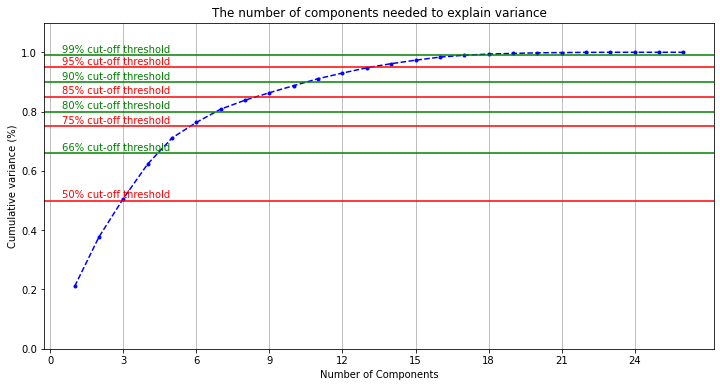

In [237]:
def print_percentile(df, n):
    pca = PCA().fit(df)
    plt.rcParams["figure.figsize"] = (12,6)
    fig, ax = plt.subplots()
    xi = np.arange(1, n, step=1)
    y = np.cumsum(pca.explained_variance_ratio_)
    plt.ylim(0.0,1.1)
    plt.plot(xi, y, marker='.', linestyle='--', color='b')
    plt.xlabel('Number of Components')
    plt.xticks(np.arange(0, n, step=3)) #change from 0-based array index to 1-based human-readable label
    plt.ylabel('Cumulative variance (%)')
    plt.title('The number of components needed to explain variance')
    plt.axhline(y=0.99, color='g', linestyle='-')
    plt.text(0.5, 1.00, '99% cut-off threshold', color = 'green', fontsize=10)
    plt.axhline(y=0.95, color='r', linestyle='-')
    plt.text(0.5, 0.96, '95% cut-off threshold', color = 'red', fontsize=10)
    plt.axhline(y=0.90, color='g', linestyle='-')
    plt.text(0.5, 0.91, '90% cut-off threshold', color = 'green', fontsize=10)
    plt.axhline(y=0.85, color='r', linestyle='-')
    plt.text(0.5, 0.86, '85% cut-off threshold', color = 'red', fontsize=10)
    plt.axhline(y=0.80, color='g', linestyle='-')
    plt.text(0.5, 0.81, '80% cut-off threshold', color = 'green', fontsize=10)
    plt.axhline(y=0.75, color='r', linestyle='-')
    plt.text(0.5, 0.76, '75% cut-off threshold', color = 'red', fontsize=10)
    plt.axhline(y=0.66, color='g', linestyle='-')
    plt.text(0.5, 0.67, '66% cut-off threshold', color = 'green', fontsize=10)
    plt.axhline(y=0.50, color='r', linestyle='-')
    plt.text(0.5, 0.51, '50% cut-off threshold', color = 'red', fontsize=10)
    ax.grid(axis='x')
    plt.show()
print_percentile(df_use, 27)

In [238]:
pca = PCA(n_components=3)
pca.fit(nparray)
pca_proj = pca.transform(nparray)
pca.explained_variance_ratio_

array([0.2104772 , 0.16700312, 0.129159  ])

NameError: name 'cmap' is not defined

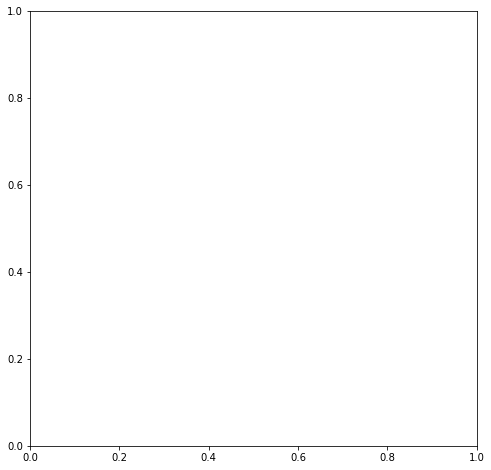

In [239]:
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = dc_class==lab
    ax.scatter(pca_proj[indices,0],pca_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

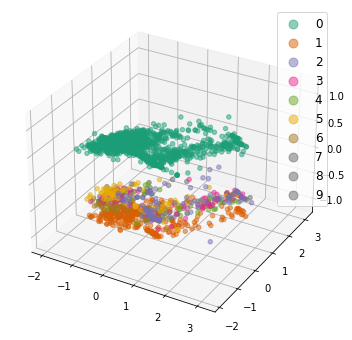

In [252]:
cmap = cm.get_cmap('Dark2')
fig = plt.figure()
ax = plt.axes(projection='3d')
num_categories = 10
for lab in range(num_categories):
    indices = dc_class==lab
    ax.scatter(pca_proj[indices, 0],
               pca_proj[indices, 1],
               pca_proj[indices, 2],
               c=np.array(cmap(lab)).reshape(1, 4),
               label=lab,
               alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

# TSNE

# mapping display category to classes

In [143]:
list(df.display_category.value_counts().index)

['OYO Rooms',
 'Capital O',
 'Premium',
 'Flagship',
 'Collection O',
 'SPOT ON',
 'Townhouse',
 'Home',
 'Silverkey',
 'Others']

In [144]:
dc_dict={'OYO Rooms':0, 'Capital O':1, 'Premium':2, 'Flagship':3, 'Collection O':4, 'SPOT ON':5,
         'Townhouse':6, 'Home':7, 'Silverkey':8, 'Others':9}

In [165]:
def map_dc(row):
    return dc_dict[row.display_category]

In [177]:
dc_class=np.array(df.apply(map_dc, axis=1))

In [170]:
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(nparray)
cmap = cm.get_cmap('tab20')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2274 samples in 0.000s...
[t-SNE] Computed neighbors for 2274 samples in 0.183s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2274
[t-SNE] Computed conditional probabilities for sample 2000 / 2274
[t-SNE] Computed conditional probabilities for sample 2274 / 2274
[t-SNE] Mean sigma: 0.260930
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.253502
[t-SNE] KL divergence after 1000 iterations: 0.741258


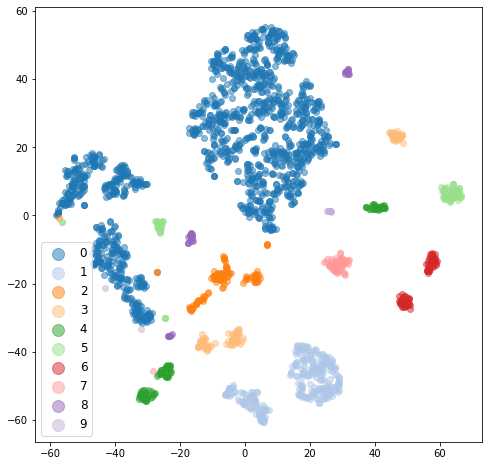

In [178]:
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = dc_class==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

In [220]:
tsne = TSNE(3, verbose=1)
tsne_proj = tsne.fit_transform(nparray)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2274 samples in 0.000s...
[t-SNE] Computed neighbors for 2274 samples in 0.164s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2274
[t-SNE] Computed conditional probabilities for sample 2000 / 2274
[t-SNE] Computed conditional probabilities for sample 2274 / 2274
[t-SNE] Mean sigma: 0.260930
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.477547
[t-SNE] KL divergence after 1000 iterations: 0.603757


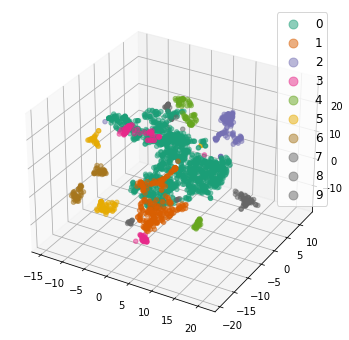

In [222]:
cmap = cm.get_cmap('Dark2')
fig = plt.figure()
ax = plt.axes(projection='3d')
num_categories = 10
for lab in range(num_categories):
    indices = dc_class==lab
    ax.scatter(tsne_proj[indices, 0],
               tsne_proj[indices, 1],
               tsne_proj[indices, 2],
               c=np.array(cmap(lab)).reshape(1, 4),
               label=lab,
               alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

# price range

In [188]:
df.fprice.describe()

count    2274.000000
mean     1658.268385
std       826.548191
min         0.000000
25%       920.022727
50%      1369.189701
75%      2541.541380
max      4669.578718
Name: fprice, dtype: float64

In [209]:
print(df[df.fprice<920.022727].count()[0])
print(df[(df.fprice>920.022727) & (df.fprice<=1369.189701)].count()[0])
print(df[(df.fprice>1369.189701) & (df.fprice<=2541.541380)].count()[0])
print(df[df.fprice>2541.541380].count()[0])

569
568
568
569


In [210]:
def map_fprice(row):
    if( row.fprice<=920.022727):
        return 0
    elif (row.fprice>920.022727) and (row.fprice<=1369.189701):
        return 1
    elif (row.fprice>1369.189701) and (row.fprice<=2541.541380):
        return 2
    return 3

In [227]:
def map_fprice1(row):
    if( row.fprice<=500):
        return 0
    elif (row.fprice>500) and (row.fprice<=1000):
        return 1
    elif (row.fprice>1000) and (row.fprice<=2000):
        return 2
    elif (row.fprice>2000) and (row.fprice<=4000):
        return 3
    return 4

In [228]:
fprice_class=np.array(df.apply(map_fprice1, axis=1))

In [233]:
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(nparray)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2274 samples in 0.001s...
[t-SNE] Computed neighbors for 2274 samples in 0.240s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2274
[t-SNE] Computed conditional probabilities for sample 2000 / 2274
[t-SNE] Computed conditional probabilities for sample 2274 / 2274
[t-SNE] Mean sigma: 0.260930
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.241730
[t-SNE] KL divergence after 1000 iterations: 0.737899


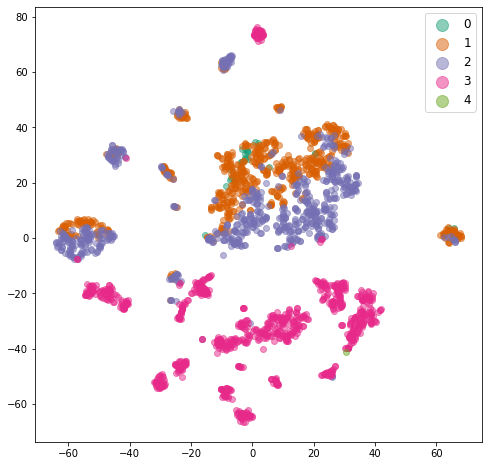

In [234]:
cmap = cm.get_cmap('Dark2')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 5
for lab in range(num_categories):
    indices = fprice_class==lab
    ax.scatter(tsne_proj[indices,0], 
               tsne_proj[indices,1], 
               c=np.array(cmap(lab)).reshape(1,4), 
               label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

In [230]:
tsne = TSNE(3, verbose=1)
tsne_proj = tsne.fit_transform(nparray)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2274 samples in 0.001s...
[t-SNE] Computed neighbors for 2274 samples in 0.182s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2274
[t-SNE] Computed conditional probabilities for sample 2000 / 2274
[t-SNE] Computed conditional probabilities for sample 2274 / 2274
[t-SNE] Mean sigma: 0.260930
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.504242
[t-SNE] KL divergence after 1000 iterations: 0.607352


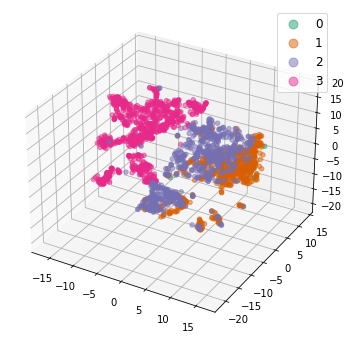

In [231]:
cmap = cm.get_cmap('Dark2')
fig = plt.figure()
ax = plt.axes(projection='3d')
num_categories = 4
for lab in range(num_categories):
    indices = fprice_class==lab
    ax.scatter(tsne_proj[indices, 0],
               tsne_proj[indices, 1],
               tsne_proj[indices, 2],
               c=np.array(cmap(lab)).reshape(1, 4),
               label=lab,
               alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

In [257]:
tsne = TSNE(2, verbose=1, metric='precomputed')
tsne_proj = tsne.fit_transform(sim)
cmap = cm.get_cmap('tab20')

/Users/oyo/opt/miniconda3/envs/similar-hotel/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


ValueError: Negative values in data passed to TSNE.fit(). With metric='precomputed', X should contain positive distances.

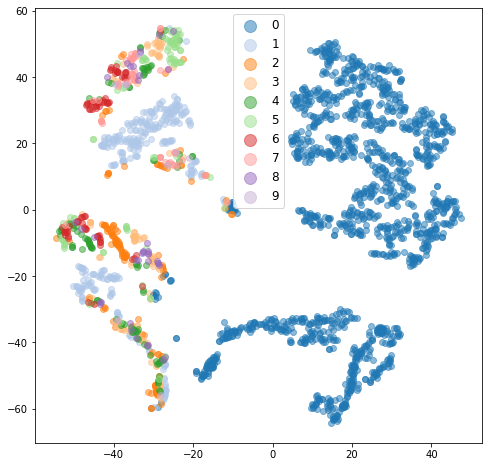

In [258]:
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = dc_class==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()